# Trabalho A2 - Análise de Séries Temporais

## Bibliotecas

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.model_selection import TimeSeriesSplit
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import itertools

## Dados

In [131]:
prison = pd.read_csv("data_updated.csv")

In [132]:
prison

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458


In [133]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

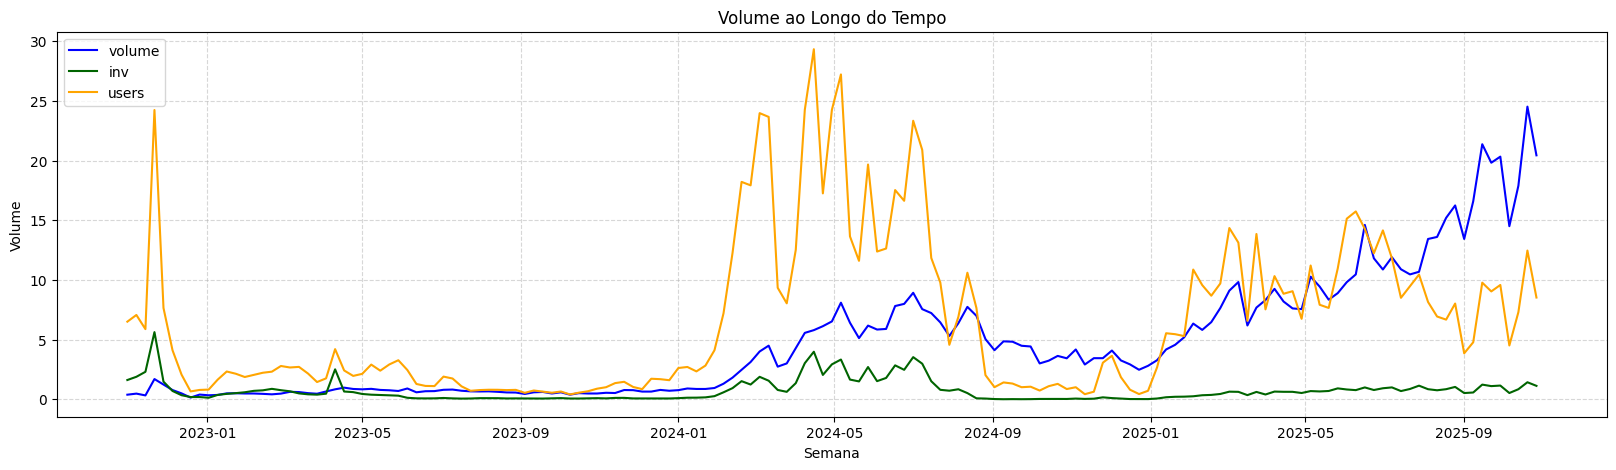

In [134]:
# Criar o gráfico
plt.figure(figsize=(20, 5))
plt.plot(prison["week"], prison["volume"], linestyle="-", marker="", color="blue", label="volume")
plt.plot(prison["week"], prison["inv"], linestyle="-", marker="", color="darkgreen", label="inv")
plt.plot(prison["week"], prison["users"], linestyle="-", marker="", color="orange", label="users")

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")
plt.legend(loc="upper left")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
plt.show()

Plots de cada variável separada

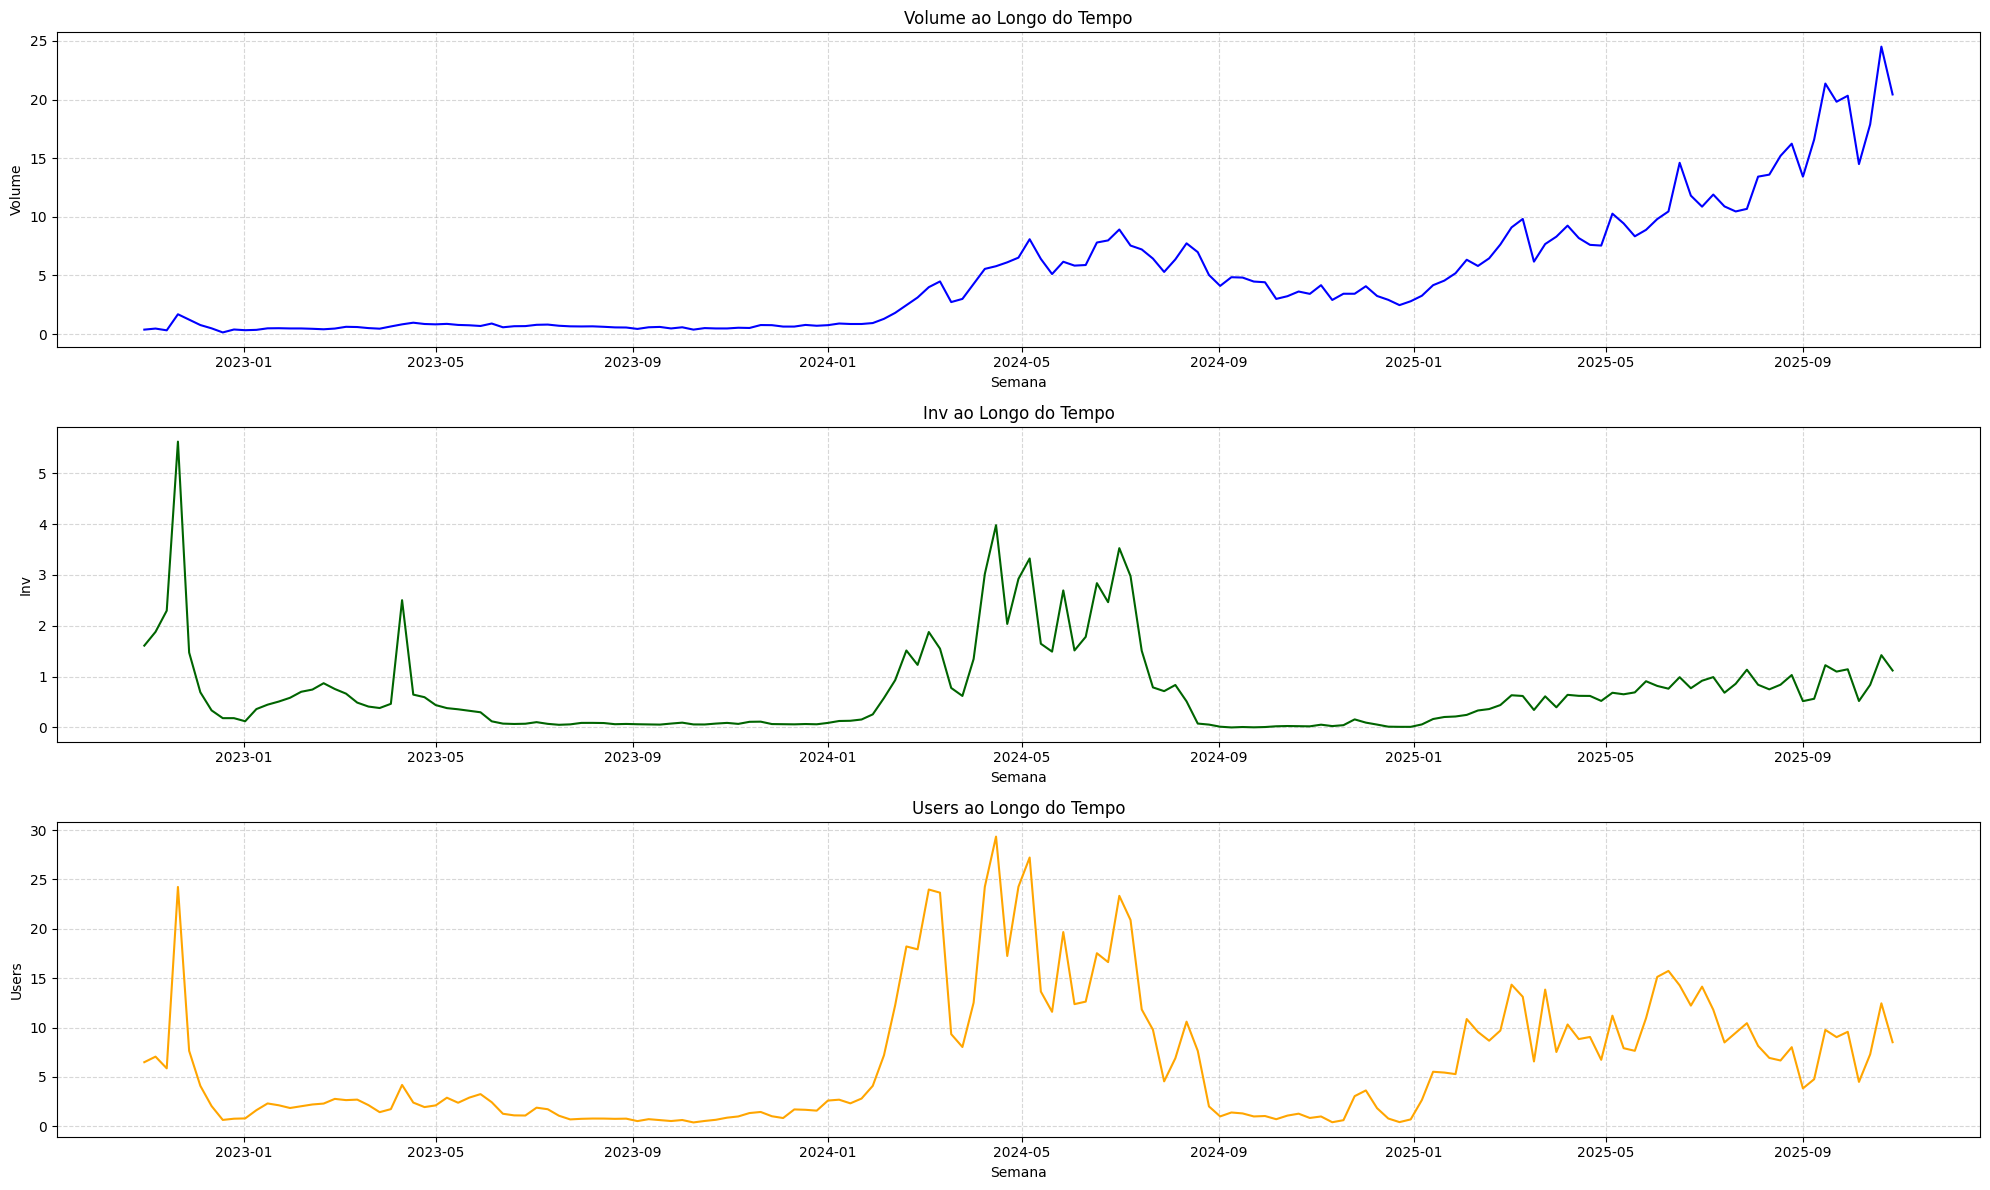

In [135]:
colors = ["blue", "darkgreen", "orange"]
columns = prison.columns

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i in range(3):
    ax = axes[i]
    column = columns[i + 1]

    ax.plot(prison["week"], prison[column], linestyle="-", marker="", color=colors[i])

    # Labels e título
    ax.set_xlabel("Semana")
    ax.set_ylabel(column.title())
    ax.set_title(f"{column.title()} ao Longo do Tempo")

    # Estilo minimalista
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Baselines

In [136]:
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]

## Baselines padrão

**Mean**: média simples de todos os dados históricos.

**Naive**: usa simplesmente o último valor observado como previsão.

**Snaive**: usa o último valor observado da mesma estação.

**Drift**: tendência linear baseada no primeiro e no último valor da série.

In [137]:
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

def calculate_metrics(name_model, yhat, y_te=y_te):
    mase_metric = MeanAbsoluteScaledError(sp=52)  
    
    row = {
        "model": name_model,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    }

    return row

## Modelos de Suavização

**SES (Simple Exponential Smoothing)**: média ponderada dos valores passados, com maior peso nos mais recentes.

**Holt**: extensão do SES que adiciona uma tendência linear suavizada.

**Holt-Winters**: versão completa que incorpora tendência e sazonalidade (aditiva ou multiplicativa).


In [138]:
# Suavização Exponencial Simples
ses_model = ExponentialSmoothing(y_tr, trend=None, seasonal=None)
ses_fit = ses_model.fit()
ses_pred = ses_fit.forecast(h)

# Holt
holt_model = ExponentialSmoothing(y_tr, trend="add", seasonal=None)
holt_fit = holt_model.fit()
holt_pred = holt_fit.forecast(h)

# Holt-Winters adaptativo 
hw_model = ExponentialSmoothing(y_tr, trend="add", seasonal="add", seasonal_periods=52)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(h)

# Holt-Winters multiplicativo
hw_mul_model = ExponentialSmoothing(y_tr, trend="add", seasonal="mul", seasonal_periods=52)
hw_mul_fit = hw_mul_model.fit()
hw_mul_pred = hw_mul_fit.forecast(h)

## Terando e comparando as Baselines

In [139]:
target_name = y_te.name

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal 
    "drift": fit_pred("drift", sp=1),
    "ses": pd.Series(ses_pred, index=y_te.index, name=target_name),
    "Holt": pd.Series(holt_pred, index=y_te.index, name=target_name),
    "Holt-Winters Adaptativo": pd.Series(hw_pred, index=y_te.index, name=target_name),
    "Holt-Winters Multiplicativo": pd.Series(hw_mul_pred, index=y_te.index, name=target_name)
}

metrics = []
for name, yhat in preds.items():
    row = calculate_metrics(name, yhat)
    metrics.append(row)

baseline_metrics = pd.DataFrame(metrics).sort_values("RMSE").round(3)
baseline_metrics

,model,MAE,RMSE,MAPE_%,MASE
7,Holt-Winters Multiplicativo,3.793,6.029,33.555,1.101
6,Holt-Winters Adaptativo,4.696,6.678,37.938,1.363
2,snaive,5.782,7.422,58.712,1.678
3,drift,5.815,7.570,48.649,1.688
5,Holt,5.815,7.570,48.649,1.688
4,ses,6.538,8.424,54.465,1.898
1,naive,6.538,8.424,54.465,1.898
0,mean,7.526,9.292,66.304,2.185


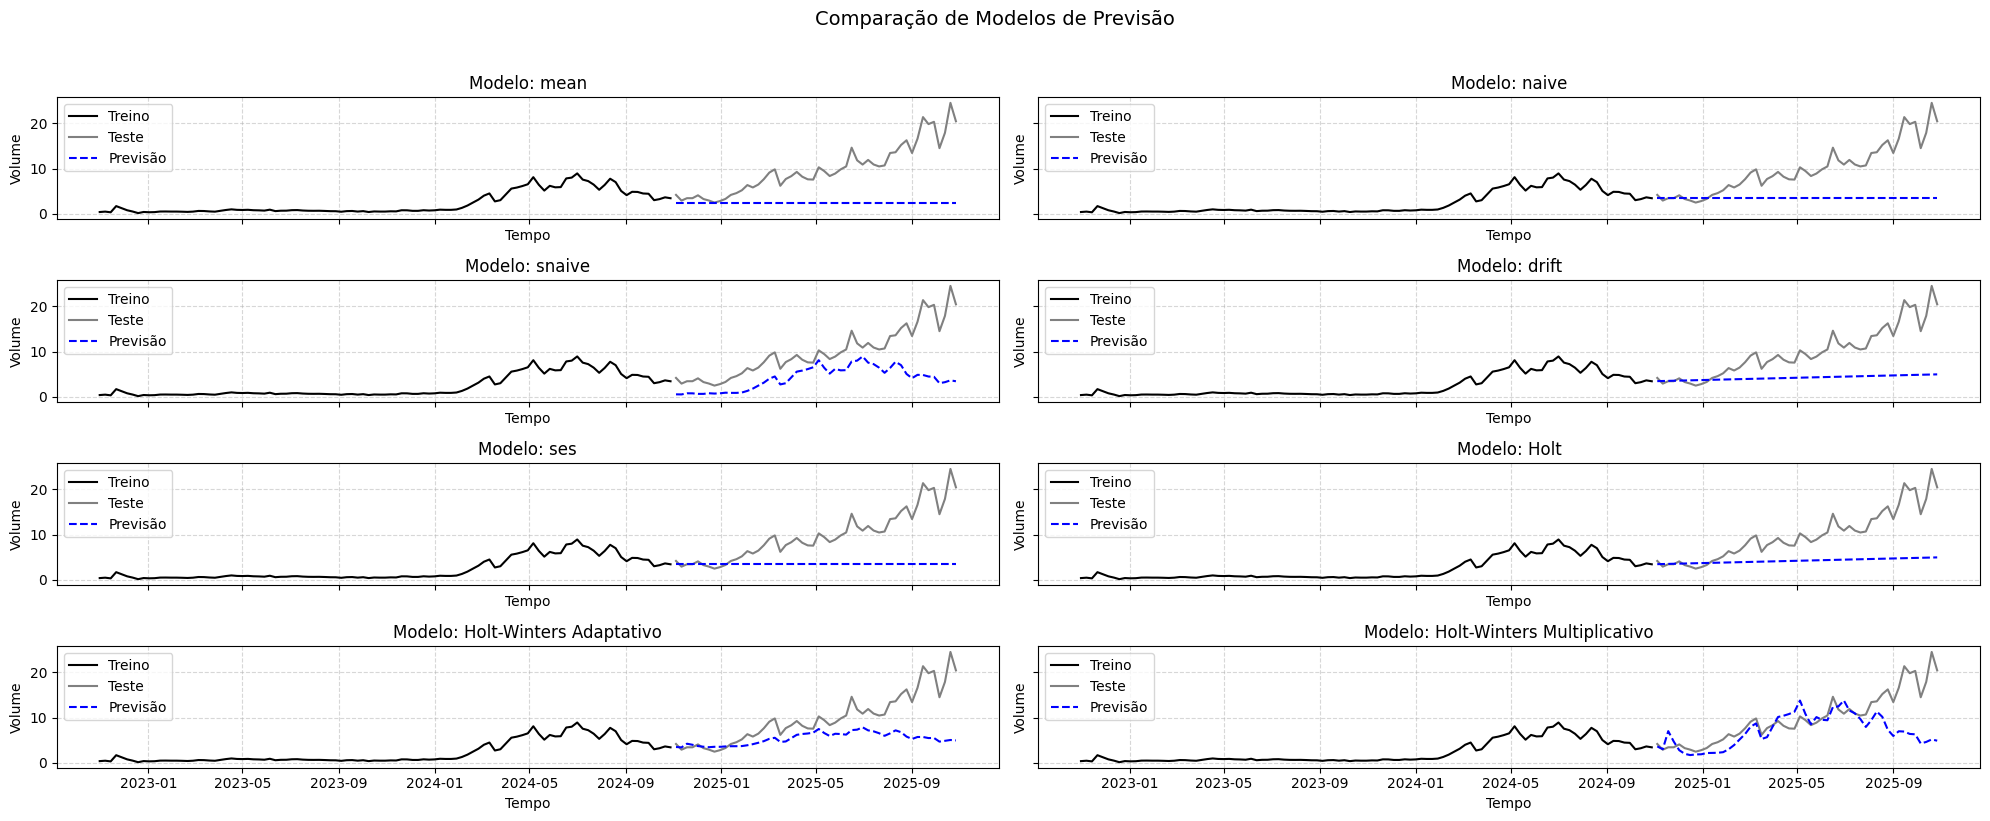

In [140]:
fig, axes = plt.subplots(4, 2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (name, yhat) in enumerate(preds.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr.index, y_tr, color="black", label="Treino")
    ax.plot(y_te.index, y_te, color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, yhat, color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Modelagem com ARIMA e SARIMA

In [141]:
X = prison.sort_values("week").set_index("week")[["inv", "users"]]
X = X.asfreq(pd.infer_freq(y.index) or "W")

h = 52

y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]


In [142]:
# escolha inicial de (p, d, q)
d = 1  # diferenciar para remover tendência
p, q = 1, 1  # ponto de partida simples
# Futuramente podemos fazer um grid search para ver quais os melhores parametros

arima = ARIMA(y_tr, order=(p, d, q)).fit()
arima_pred = arima.forecast(steps=h)

arima_metrics = calculate_metrics("ARIMA", arima_pred)
metrics.append(arima_metrics)

arima_metrics = pd.DataFrame([arima_metrics])
arima_metrics

c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\sktime\performance_metrics\forecasting\_base.py:671: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,model,MAE,RMSE,MAPE_%,MASE
0,ARIMA,6.5346,8.421115,54.43769,1.896888


In [143]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

sarima = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_pred = sarima.forecast(steps=h)

sarima_metrics = calculate_metrics("SARIMA", sarima_pred)
metrics.append(sarima_metrics)

sarima_metrics = pd.DataFrame([sarima_metrics]).round(3)
sarima_metrics

c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\sktime\performance_metrics\forecasting\_base.py:671: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMA,3.262,5.461,25.376,0.947


In [144]:
sarimax = SARIMAX(
    y_tr,
    exog=X_tr,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

sarimax_pred = sarimax.forecast(steps=h, exog=X_te)
sarimax_pred = pd.Series(sarimax_pred, index=y_te.index, name=y_te.name)

sarimax_metrics = calculate_metrics("SARIMAX", sarimax_pred)
metrics.append(sarimax_metrics)
sarimax_metrics = pd.DataFrame([sarimax_metrics]).round(3)
sarimax_metrics

c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMAX,3.146,5.195,24.256,0.913


In [145]:
metrics = pd.DataFrame(metrics).sort_values("RMSE").reset_index().drop(columns="index").round(3)
metrics

,model,MAE,RMSE,MAPE_%,MASE
0,SARIMAX,3.146,5.195,24.256,0.913
1,SARIMA,3.262,5.461,25.376,0.947
2,Holt-Winters Multiplicativo,3.793,6.029,33.555,1.101
3,Holt-Winters Adaptativo,4.696,6.678,37.938,1.363
4,snaive,5.782,7.422,58.712,1.678
5,drift,5.815,7.570,48.649,1.688
6,Holt,5.815,7.570,48.649,1.688
7,ARIMA,6.535,8.421,54.438,1.897
8,ses,6.538,8.424,54.465,1.898
9,naive,6.538,8.424,54.465,1.898


# Medindo Correlações

*LEMBRAR DE MUDAR A POSIÇÃO DESSA SEÇÃO DE ACORDO COM A NECESSIDADE

In [146]:
corr_pearson_matrix = prison[["volume", "inv", "users"]].corr("pearson")
corr_spearman_matrix = prison[["volume", "inv", "users"]].corr("spearman")
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]  # até 20 defasagens
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

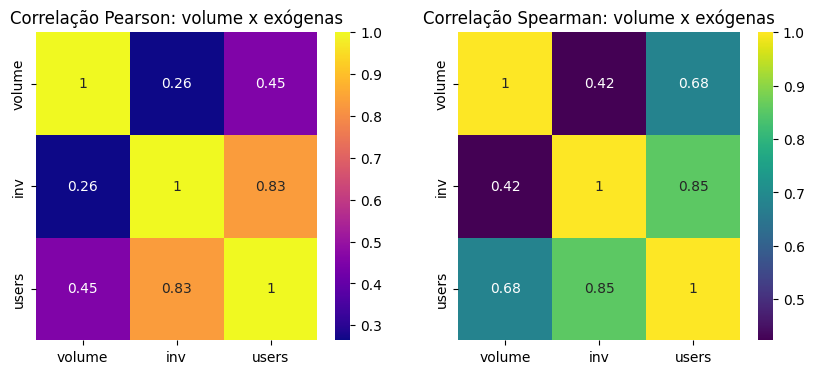

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(corr_pearson_matrix, ax=axes[0], annot=True, cmap="plasma")
axes[0].set_title("Correlação Pearson: volume x exógenas")

sns.heatmap(corr_spearman_matrix, ax=axes[1], annot=True, cmap="viridis")
axes[1].set_title("Correlação Spearman: volume x exógenas")

plt.show()


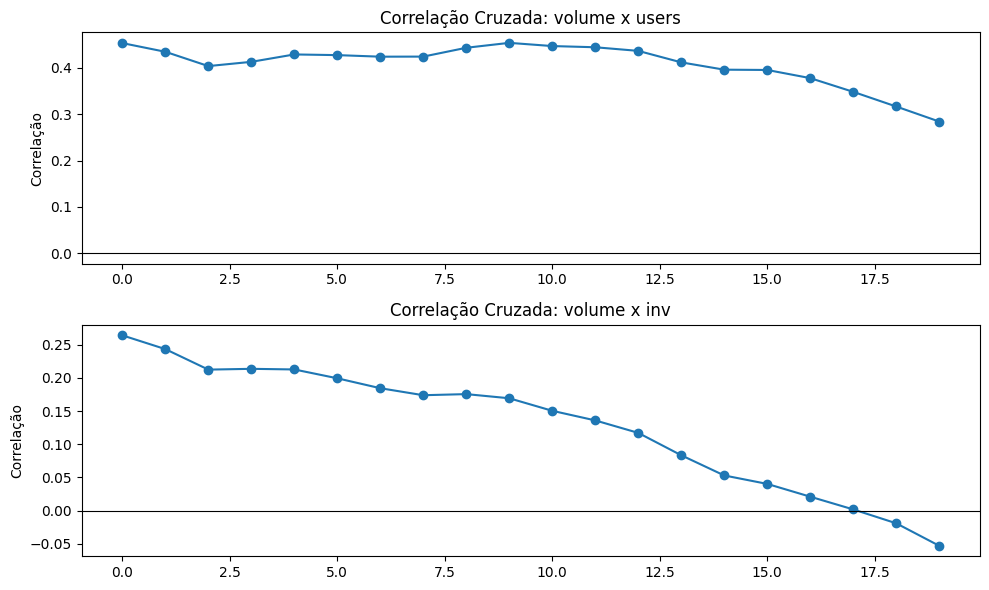

In [148]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# cross-correlation até 20 defasagens
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

axes[0].plot(range(len(cross_corr_us_x_vol)), cross_corr_us_x_vol, marker="o")
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_title("Correlação Cruzada: volume x users")
axes[0].set_ylabel("Correlação")

axes[1].plot(range(len(cross_corr_inv_x_vol)), cross_corr_inv_x_vol, marker="o")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_title("Correlação Cruzada: volume x inv")
axes[1].set_ylabel("Correlação")

plt.tight_layout()
plt.show()


## Após Aplicação da Transformação Box-Cox na Variável Volume

In [149]:
prison = prison.set_index("week")
y = prison["volume"]

y_bc, lmbda = boxcox(y)

print(f"O valor de lambda (λ) é: {lmbda:.4f}")

O valor de lambda (λ) é: 0.0381


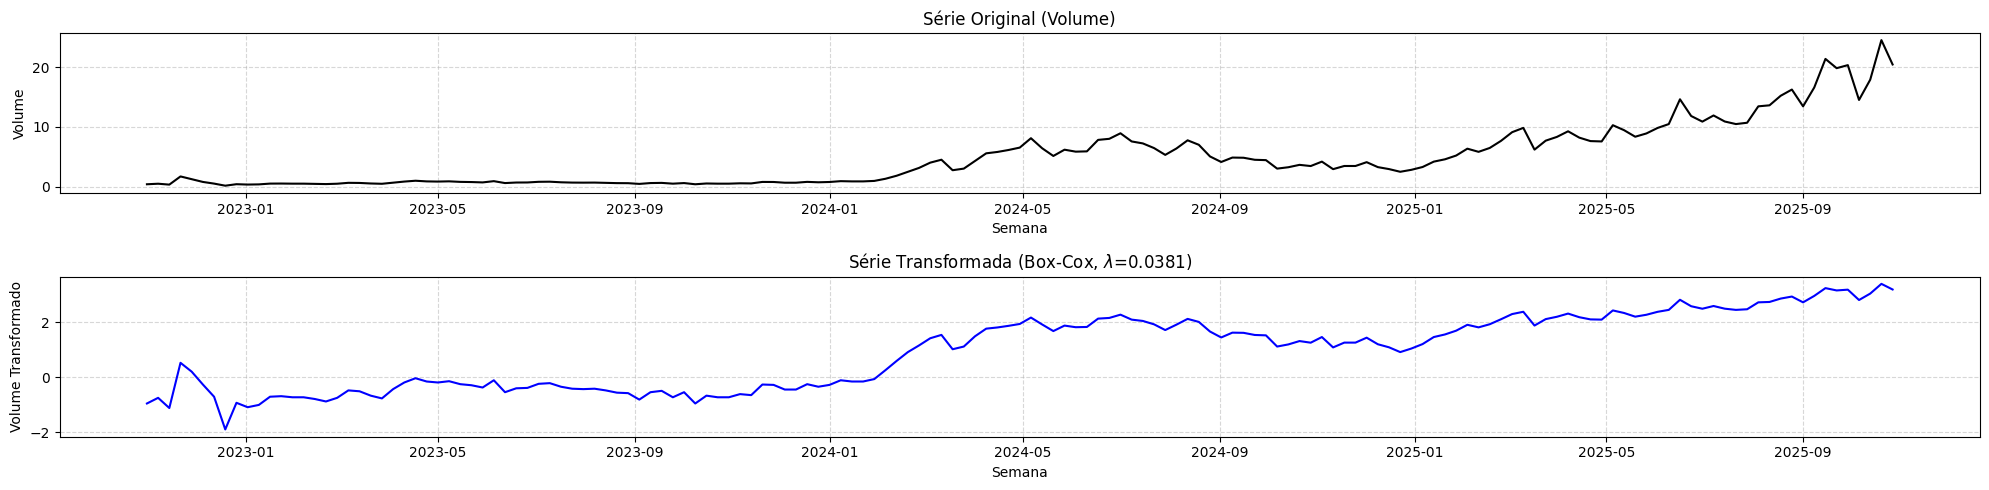

In [150]:
# Armazena a série transformada no DataFrame para futuras modelagens
prison["volume_bc"] = y_bc

# Criar o gráfico
fig, axes = plt.subplots(2, 1, figsize=(20, 5))

# Série Original
axes[0].plot(prison["volume"], linestyle="-", color="black")
axes[0].set_title("Série Original (Volume)")
axes[0].set_ylabel("Volume")
axes[0].set_xlabel("Semana")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Série Transformada
axes[1].plot(prison["volume_bc"], linestyle="-", color="blue")
axes[1].set_title(f"Série Transformada (Box-Cox, $\\lambda$={lmbda:.4f})")
axes[1].set_ylabel("Volume Transformado")
axes[1].set_xlabel("Semana")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [151]:
y_bc = prison["volume_bc"]
y_bc = y_bc.asfreq(pd.infer_freq(y_bc.index) or "W")

h = 52
y_tr_bc, y_te_bc = y_bc.iloc[:-h], y_bc.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred_bc(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr_bc)
    return f.predict(fh)

preds_bc = {
    "mean":  fit_pred_bc("mean", sp=1),
    "naive": fit_pred_bc("last", sp=1),
    "snaive": fit_pred_bc("last", sp=52),
    "drift": fit_pred_bc("drift", sp=1),
}

metrics_bc = []
for name, yhat in preds_bc.items():
    row = calculate_metrics(name, yhat, y_te_bc)
    metrics_bc.append(row)

metrics_baselines_bc = pd.DataFrame(metrics_bc).sort_values("RMSE").round(3)
metrics_baselines_bc

,model,MAE,RMSE,MAPE_%,MASE
3,drift,0.470,0.533,20.514,NaN
1,naive,0.993,1.156,40.061,NaN
2,snaive,1.080,1.215,57.806,NaN
0,mean,1.928,2.035,85.461,NaN


# Modelo de Regressão

Aplica-se validação cruzada temporal (5 folds), respeitando a ordem cronológica para evitar vazamento de informação

In [152]:
# CV temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def cv_score_for_subset(subset, y, metric, *args):
    X_sub = subset.values
    scores = []
    for train_index, val_index in tscv.split(X_sub):
        X_tr, X_val = X_sub[train_index], X_sub[val_index]
        y_tr, y_val = y.values[train_index], y.values[val_index]

        model = LinearRegression()
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict(X_val)

        if args is not None:
            scores.append(metric(y_val, y_pred, square_root=args))
        else:
            scores.append(metric(y_val, y_pred))

    return np.mean(scores), np.std(scores)

In [153]:
# Criando dataframe para a regressão
df = prison.reset_index().copy()

Variáveis criadas a partir de `volume`

In [154]:
# Extrai features temporais
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df["weekofyear"] = df["week"].dt.isocalendar().week.astype(int)

# Criar defasagens (lags)
df["lag1"] = df["volume"].shift(1)
df["lag2"] = df["volume"].shift(2)
df["lag52"] = df["volume"].shift(52)  # captura sazonalidade anual

# Cria médias móveis
df["rolling_mean_4"] = df["volume"].shift(1).rolling(4).mean()
df["rolling_mean_12"] = df["volume"].shift(1).rolling(12).mean()

Variáveis criadas a partir das variáveis exógenas de prison

In [155]:
# Defasagens
df["inv_lag1"] = df["inv"].shift(1)
df["inv_lag4"] = df["inv"].shift(4)
df["users_lag1"] = df["users"].shift(1)
df["users_lag4"] = df["users"].shift(4)

# Médias móveis
df["inv_roll4"] = df["inv"].shift(1).rolling(4).mean()
df["users_roll4"] = df["users"].shift(1).rolling(4).mean()

# Cresciemnto/diferenças
df["inv_diff"] = df["inv"].diff()
df["users_diff"] = df["users"].diff()

df["inv_pct_change"] = df["inv"].pct_change()
df["users_pct_change"] = df["users"].pct_change()


Interações das variáveis também podem ser úteis

In [156]:
df["inv_x_users"] = df["inv"] * df["users"]
df["volume_x_users"] = df["volume"] * df["users"]
df["volume_x_inv"] = df["volume"] * df["inv"]

In [157]:
# Removendo possíveis NaNs
df = df.dropna()
df

,week,volume,inv,users,volume_bc,year,month,weekofyear,lag1,lag2,...,users_lag4,inv_roll4,users_roll4,inv_diff,users_diff,inv_pct_change,users_pct_change,inv_x_users,volume_x_users,volume_x_inv
52,2023-10-30,0.48,0.089483,0.883,-0.723805,2023,10,44,0.48,0.51,...,0.646,0.071987,0.56650,0.013477,0.214,0.177320,0.319880,0.079013,0.42384,0.042952
53,2023-11-06,0.54,0.069813,1.007,-0.609012,2023,11,45,0.48,0.48,...,0.401,0.070807,0.62575,-0.019669,0.124,-0.219811,0.140430,0.070302,0.54378,0.037699
54,2023-11-13,0.52,0.110762,1.351,-0.645850,2023,11,46,0.54,0.48,...,0.550,0.073396,0.77725,0.040948,0.344,0.586538,0.341609,0.149639,0.70252,0.057596
55,2023-11-20,0.77,0.113805,1.460,-0.260068,2023,11,47,0.52,0.54,...,0.669,0.086516,0.97750,0.003043,0.109,0.027475,0.080681,0.166155,1.12420,0.087630
56,2023-11-27,0.76,0.066669,1.027,-0.273008,2023,11,48,0.77,0.52,...,0.883,0.095966,1.17525,-0.047136,-0.433,-0.414183,-0.296575,0.068469,0.78052,0.050668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575,3.191674,2025,9,40,19.82,21.37,...,3.847,0.851238,6.85575,0.045424,0.540,0.041336,0.059768,10.957092,194.65975,23.264510
153,2025-10-06,14.50,0.520285,4.504,2.815073,2025,10,41,20.33,19.82,...,4.773,1.008020,8.28775,-0.624059,-5.071,-0.545342,-0.529608,2.343362,65.30800,7.544128
154,2025-10-13,17.89,0.837998,7.296,3.048625,2025,10,42,14.50,20.33,...,9.768,0.997045,8.22050,0.317714,2.792,0.610654,0.619893,6.114037,130.52544,14.991793
155,2025-10-20,24.52,1.422242,12.458,3.402597,2025,10,43,17.89,14.50,...,9.035,0.900387,7.60250,0.584244,5.162,0.697190,0.707511,17.718296,305.47016,34.873385


Definindo X e y do modelo.

Inicialmente, X possui todas as variáveis exceto `volume` (variáveis exógenas e derivadas).

In [158]:
X = df[[
    "inv","users","inv_x_users", "volume_x_users",
    "volume_x_inv","year","month","weekofyear",
    "lag1","lag2","lag52",#"rolling_mean_4","rolling_mean_12",
    "inv_lag1","users_lag1",#"inv_roll4","users_roll4",
    "inv_diff","users_diff"
]]

y = df["volume"]

In [159]:
h = 52

X_train, X_test = X.iloc[:-h].copy(), X.iloc[-h:].copy()
y_train, y_test = y.iloc[:-h].copy(), y.iloc[-h:].copy()

# Adiciona intercepto
X_train = sm.add_constant(X_train)
X_test["const"] = np.ones(X_test.shape[0])
X_test = X_test[X_train.columns]

cols = X.columns.tolist()

Primeiro vamos fazer uma regressão apenas com as variáveis exógenas

In [160]:
simple_model = sm.OLS(y_train, X_train[["inv", "users"]]).fit()

pred_res = simple_model.get_prediction(X_test[["inv", "users"]])
summary = pred_res.summary_frame()

pred_means = summary["mean"].values
pred_lower = summary["mean_ci_lower"].values
pred_upper = summary["mean_ci_upper"].values
pred_index = X_test.index.tolist()

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

residuos_best = y_test - y_pred

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(simple_model.summary())

MAE:  7.52412234337745
RMSE:  8.975241391743152
                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.722
Model:                            OLS   Adj. R-squared (uncentered):              0.711
Method:                 Least Squares   F-statistic:                              66.28
Date:                seg, 01 dez 2025   Prob (F-statistic):                    6.55e-15
Time:                        11:15:15   Log-Likelihood:                         -123.69
No. Observations:                  53   AIC:                                      251.4
Df Residuals:                      51   BIC:                                      255.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      

In [123]:
# busca exaustiva (todas as combinações)
results = []
for k in range(1, len(cols)):
    for subset in itertools.combinations(cols, k):
        mean_MAE_score, std_MAE_score = cv_score_for_subset(X[list(subset)], y, mean_absolute_error)
        mean_RMSE_score, std_RMSE_score = cv_score_for_subset(X[list(subset)], y, mean_squared_error, False)
        results.append({
            "subset": subset,
            "k": k,
            "mean MAE": mean_MAE_score,
            "std MAE": std_MAE_score,
            "mean RMSE": mean_RMSE_score,
            "std RMSE": std_RMSE_score
        })

res_df = pd.DataFrame(results).sort_values("mean MAE")
res_df

,subset,k,mean MAE,std MAE,mean RMSE,std RMSE
3841,"(inv_x_users, volume_x_inv, year, lag1, users_...",5,0.919932,0.366759,1.164220,0.463610
8625,"(inv_x_users, volume_x_inv, year, lag1, inv_di...",6,0.928041,0.384988,1.183277,0.490399
10832,"(inv, users, volume_x_inv, year, lag1, inv_lag...",7,0.929360,0.365365,1.168192,0.495747
5347,"(inv, users, volume_x_inv, year, lag1, inv_diff)",6,0.929360,0.365365,1.168192,0.495747
5345,"(inv, users, volume_x_inv, year, lag1, inv_lag1)",6,0.929360,0.365365,1.168192,0.495747
...,...,...,...,...,...,...
11213,"(inv, users, weekofyear, inv_lag1, users_lag1,...",7,5.379267,2.982747,5.857542,3.108686
3617,"(users, weekofyear, inv_lag1, users_lag1, inv_...",5,5.379267,2.982747,5.857542,3.108686
124,"(inv, users, month)",3,5.406573,3.064222,5.861486,3.158717
125,"(inv, users, weekofyear)",3,5.414495,3.034151,5.860377,3.137478


In [124]:
best_features = list(res_df.iloc[0]["subset"])
best_features

['inv_x_users', 'volume_x_inv', 'year', 'lag1', 'users_diff']

In [163]:
final_model = sm.OLS(y_train, X_train[best_features]).fit()

pred_res = final_model.get_prediction(X_test[best_features])
summary = pred_res.summary_frame()

pred_means = summary["mean"].values
pred_lower = summary["mean_ci_lower"].values
pred_upper = summary["mean_ci_upper"].values
pred_index = X_test.index.tolist()

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

residuos_best = y_test - y_pred

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(final_model.summary())

MAE:  1.2823420635858986
RMSE:  1.78031436898509
                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              741.1
Date:                seg, 01 dez 2025   Prob (F-statistic):                    3.42e-44
Time:                        11:53:09   Log-Likelihood:                         -42.110
No. Observations:                  53   AIC:                                      94.22
Df Residuals:                      48   BIC:                                      104.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025   

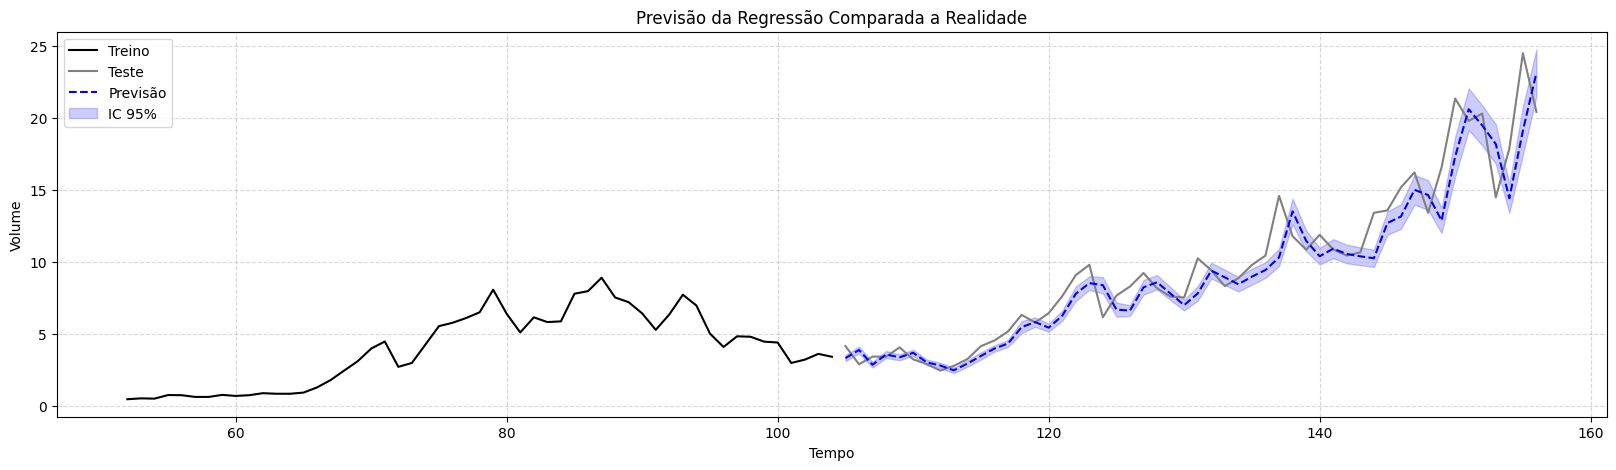

In [165]:
# Cria um grid 2x2 de subplots
plt.figure(figsize=(20, 5))

plt.plot(y_train.index, y_train, color="black", label="Treino")
plt.plot(y_test.index, y_test, color="gray", label="Teste")

plt.plot(y_test.index, y_pred, color="blue", linestyle="--", label="Previsão")
    
# intervalo de confiança
plt.fill_between(y_test.index, pred_lower.values, pred_upper.values,
                 color="blue", alpha=0.2, label="IC 95%")
    
plt.title("Previsão da Regressão Comparada a Realidade")
plt.xlabel("Tempo")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.show()